##Date:  May 18th, 2015

This is to test features, with the multi-class classification problem of rating words

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import requests
from pattern import web
import operator

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import label_binarize
from unidecode import unidecode
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

In [3]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

In [4]:
talks_small = pd.read_json('train2.json')

In [5]:
talks_small.reset_index(drop = True, inplace = True)

In [6]:
talks_small.shape

(1535, 33)

In [7]:
talks_small['onespeaker'] = (talks_small['onespeaker']==True).astype(int)

In [8]:
def themes_fun(row):
    # note this function should be applied to the whole df
    themes = []
    for theme in row['themes']:
        themes.append(theme['theme']['name'])
    return themes

In [9]:
themes = []
for i in xrange(talks_small.shape[0]):
    themes.append(themes_fun(talks_small.ix[i,:]))

In [10]:
# get the total themes, used as vocabulary
th_url = 'https://api.ted.com/v1/themes.json?api-key=ynw2u8e4h9sk8c2htp7vutxq&limit=100'
th_res = requests.get(th_url)

In [11]:
vocab = [(x['theme']['name'],x['theme']['id']) for x in th_res.json()['themes']]

In [12]:
vocab = dict(vocab)

In [13]:
vocab = vocab.keys()

In [14]:
vocab[1]

u'Celebrating TEDWomen'

In [15]:
length_of_themes = []
for theme in vocab:
    length_of_themes.append(len(theme))

In [16]:
length_of_themes.sort()

##### The maximum length of all themes is 35 

In [17]:
talks_small['themes'] = themes

In [18]:
talks_small['themes'] = talks_small['themes'].apply(lambda x: ' '.join(x))

In [19]:
talks_small.themes[7]

u'The Creative Spark Spectacular Performance Art Unusual Live Music'

In [20]:
# shortest themes are of 2 words, longest 7words
Cvtheme = CountVectorizer(vocabulary=vocab,binary = True, analyzer='char',ngram_range=(2,40),lowercase = False)

In [21]:
test = talks_small['themes'].as_matrix()

In [22]:
test.shape

(1535,)

In [23]:
testout = Cvtheme.fit_transform(test)

In [24]:
testout.shape

(1535, 47)

In [25]:
testout=testout.toarray()

In [26]:
# the longest combined themes
(talks_small.themes.apply(lambda x:len(x))).idxmax()

1468

In [27]:
testout[1468,:]

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0])

In [28]:
talks_small.themes[1468]

u'The Creative Spark How the Mind Works Presentation Innovation Tales of Invention Master Storytellers Technology, History and Destiny Unconventional Explanations What Makes Us Happy? Whipsmart Comedy Words About Words'

In [29]:
np.nonzero(testout[1468,:])

(array([ 2,  7,  9, 10, 18, 20, 21, 30, 36, 40]),)

In [30]:
vocab[7]

u'What Makes Us Happy?'

In [31]:
captalkid = talks_small['id']

In [32]:
labels = pd.read_csv('response5.csv',header =None )

In [33]:
labels.columns = ['id','label']

In [34]:
labels.head()

,id,label
0,1,4
1,2,1
2,2167,0
3,3,0
4,99,4


###Make a plot of label distribution 

In [35]:
counts = labels.groupby('label')['label'].count()

In [36]:
counts.sum()

1535

In [37]:
type(counts)

pandas.core.series.Series

In [38]:
fractions = counts/counts.sum()

In [39]:
fractions.index = ['persuasive informative','beautiful courageous inspiring','jaw-dropping ingenious fascinating',
                  'ok obnoxious confusing unconvincing long-winded', 'funny']

In [40]:
fractions

persuasive informative                             0.308795
beautiful courageous inspiring                     0.272313
jaw-dropping ingenious fascinating                 0.229967
ok obnoxious confusing unconvincing long-winded    0.116612
funny                                              0.072313
Name: label, dtype: float64

In [41]:
type(fractions)

pandas.core.series.Series

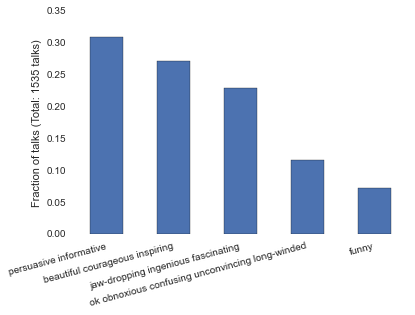

In [42]:
fractions.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Fraction of talks (Total: 1535 talks)')

## 1. Look at the prediction power of feature 

### 1.1 negative rating words frequency 

In [43]:
talks_small = pd.merge(talks_small,labels,on = 'id')

In [44]:
talks_small.head()

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,...,published_at,rating_count,recorded_at,released_at,speaker_gender,speaker_ids,themes,updated_at,viewed_count,label
0,50,51,126,100,460,383,50,356,85,95,...,2006-06-27 00:11:00,2485,2006-02-25,2013-12-02 21:24:10,1,[2],Presentation Innovation A Greener Future? Bold...,2014-11-05 16:39:29,2842062,4
1,45,NaN,128,139,15,236,269,432,61,14,...,2006-08-15 00:11:00,1511,2006-02-24,2013-12-12 20:29:35,0,[3],A Greener Future? Tales of Invention Rethinkin...,2015-04-11 07:03:32,956392,1
2,489,17,53,739,838,890,154,1591,66,28,...,2011-05-11 14:14:00,5705,2011-03-02,2014-05-24 17:21:56,1,[990],How the Mind Works What Makes Us Happy?,2014-12-21 10:34:53,3831926,1
3,157,95,51,200,99,58,140,140,62,31,...,2012-04-06 15:40:36,1806,2012-02-27,2014-07-15 15:56:08,0,[1272],Architectural Inspiration Design That Matters ...,2014-12-27 10:03:01,1370234,3
4,242,16,48,2380,148,1491,731,825,1015,25,...,2009-04-08 01:00:00,7389,2009-02-06,2014-08-12 14:34:11,0,[328],Animals That Amaze Evolution's Genius Unconven...,2014-08-12 14:34:11,1777464,2


In [45]:
talks_small['neg_rating_count']=talks_small[['Confusing','Obnoxious','Unconvincing','Longwinded','OK']].sum(axis = 1)

In [46]:
talks_small['neg_ratio'] = talks_small['neg_rating_count']/talks_small['rating_count']

In [47]:
talks_small['neg_binary']= talks_small['label']==3

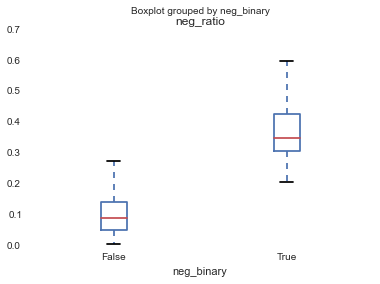

In [48]:
talks_small.boxplot(column = 'neg_ratio',by = 'neg_binary')

so the clustered negatively rated talks do have evident overall negative rating

In [49]:
talks_small['neg_fun_count'] = talks_small[['Funny','Confusing','Obnoxious','Unconvincing','Longwinded','OK']].sum(axis = 1)

In [50]:
talks_small['neg_fun_freq'] = talks_small.neg_fun_count/talks_small.rating_count

### Now watch a few typical talks for each class 

In [51]:
negmax = talks_small.neg_ratio.max()

In [52]:
negmin = talks_small.neg_ratio.min()

In [53]:
# make a label dict: key: label; value: words
labeldict = {}

In [54]:
labeldict[2]=['Fascinating', 'Ingenious', 'Jaw-dropping']
labeldict[0]=['Informative', 'Persuasive']
labeldict[3]=['Confusing', 'Longwinded', 'OK', 'Obnoxious', 'Unconvincing']
labeldict[1]=['Beautiful','Courageous','Inspiring']
labeldict[4]=['Funny']

In [55]:
labeldict

{0: ['Informative', 'Persuasive'],
 1: ['Beautiful', 'Courageous', 'Inspiring'],
 2: ['Fascinating', 'Ingenious', 'Jaw-dropping'],
 3: ['Confusing', 'Longwinded', 'OK', 'Obnoxious', 'Unconvincing'],
 4: ['Funny']}

In [113]:
# define a function with input: label class,num, how many max and min output ids for best and worst 
def select_talks(label,num=1):
    talks = talks_small.copy()
    ratingwords = labeldict[label]
    talks['thislabelcount']=talks[ratingwords].sum(axis = 1)
    talks['thislabelratio']=talks['thislabelcount']/talks['rating_count']
    maxid = [];minid = []
    for i in xrange(num):
        max_ind = talks['thislabelratio'].idxmax()
        min_ind = talks['thislabelratio'].idxmin()
        maxid.append(talks.ix[max_ind,'id'])
        minid.append(talks.ix[min_ind,'id'])
        allid = maxid + minid
        talks = talks[~talks['id'].isin(allid)]
    return maxid,minid

In [136]:
def select_talks2(labels,num = 1,arithmetic = 'plus'):
    # this is to select talks based on the rating counts of TWO labels, also need to define arithmetic: plus or minus
    talks = talks_small.copy()
    label1, label2 = labels[0],labels[1]
    words1,words2 = labeldict[label1],labeldict[label2]
    talks['words1count'] = talks[words1].sum(axis = 1)
    words1_fraction = talks['words1count']/talks['rating_count']
    talks['words2count'] = talks[words2].sum(axis = 1)
    words2_fraction = talks['words2count']/talks['rating_count']
    if arithmetic == 'plus':
        talks['ari_fraction'] = words1_fraction + words2_fraction
    else:
        talks['ari_fraction'] = words1_fraction - words2_fraction
    maxid = [];minid = []
    for i in xrange(num):
        max_ind = talks['ari_fraction'].idxmax()
        min_ind = talks['ari_fraction'].idxmin()
        maxid.append(talks.ix[max_ind,'id'])
        minid.append(talks.ix[min_ind,'id'])
        allid = maxid + minid
        talks = talks[~talks['id'].isin(allid)]
    return maxid,minid

In [151]:
maxid,minid = select_talks2([2,0],3,'minus')

In [157]:
for ind in maxid:
    print talks_small[talks_small['id']==ind][['id','name','label']]

      id                                               name  label
603  129  Blaise Agüera y Arcas: How PhotoSynth can conn...      2
     id                                               name  label
228  65  Jeff Han: The radical promise of the multi-tou...      2
       id                                            name  label
1208  199  Arthur Benjamin: A performance of "Mathemagic"      2


In [156]:
for ind in minid:
    print talks_small[talks_small['id']==ind][['id','name','label']]

      id                                   name  label
683  152  Ngozi Okonjo-Iweala: Aid versus trade      0
      id                                               name  label
351  899  Stephen Palumbi: Hidden toxins in the fish we eat      0
     id                                               name  label
561  10  Dean Ornish: The killer American diet that's s...      0


In [57]:
maxid, minid = select_talks(3,6)

In [158]:
print maxid, minid

[129, 65, 199] [152, 899, 10]


In [139]:
talks_small[talks_small['id']==114
           ][['name','rating_count','neg_ratio','Funny','Confusing','Unconvincing','Obnoxious','OK',
                                   'Longwinded']]

,name,rating_count,neg_ratio,Funny,Confusing,Unconvincing,Obnoxious,OK,Longwinded
793,Tom Rielly: A comic sendup of TED2006,1122,0.28877,572,56,34,116,64,54


In [60]:
(95+619+137+77+89)/1517.

0.6704021094264997

In [61]:
talks_small.speaker_ids[0]

[2]

In [62]:
labels['label'].value_counts()

0    474
1    418
2    353
3    179
4    111
dtype: int64

In [63]:
labels.head()

,id,label
0,1,4
1,2,1
2,2167,0
3,3,0
4,99,4


In [64]:
talks_small['id'].head()

0       1
1       2
2    1143
3    1413
4     509
Name: id, dtype: int64

### 1.2 Stemming/Lemmatization of keywords and descriptions: not implemented

In [31]:
# test with one description
test = talks_small.description[0]

In [32]:
test

u'With the same humor and humanity he exuded in <em>An Inconvenient Truth,</em> Al Gore spells out 15 ways that individuals can address climate change immediately, from buying a hybrid to inventing a new, hotter "brand name" for global warming.'

In [33]:
stemmer = PorterStemmer()

In [37]:
descriptions = talks_small.description

In [38]:
def stem_fun(corpus):
    stemed = [stemmer.stem(token) for token in word_tokenize(corpus)]
    return ' '.join(stemed)

In [39]:
descriptions = [stem_fun(corpus) for corpus in descriptions]

In [40]:
talks_small['desc_stemmed'] = descriptions

stemming tried, not working, generated higher dimension

#####Lemmatization only noun and verb: unfinished

In [652]:
lemmatizer = WordNetLemmatizer()

In [436]:
test = talks_small.description[0]

In [657]:
test = pos_tag(word_tokenize(test))

In [663]:
def lemmatize(token, tag):
    if tag[0].lower() in ['n', 'v']:
        return lemmatizer.lemmatize(token, tag[0].lower())
    return token

In [664]:
test_lemmed = [lemmatize(x[0],x[1]) for x in test]

## 2 Gather all potential features into one df, serve as X, y is the label 

In [106]:
# if separate tags vs themes are wanted then go to the talks_f.json
# talks_all = pd.read_json('talks_f.json')
# talks_all.reset_index(drop = True, inplace = True)

### 2.1 First trial: features are from the talks_small and captions_f.csv

#### look at the number of available languages

In [65]:
talks_small.columns

Index([           u'Beautiful',            u'Confusing',
                 u'Courageous',          u'Fascinating',
                      u'Funny',          u'Informative',
                  u'Ingenious',            u'Inspiring',
               u'Jaw-dropping',           u'Longwinded',
                         u'OK',            u'Obnoxious',
                 u'Persuasive',         u'Unconvincing',
            u'commented_count',          u'description',
              u'emailed_count',             u'event_id',
                         u'id',             u'keywords',
                  u'languages',                 u'name',
       u'native_language_code',           u'onespeaker',
               u'published_at',         u'rating_count',
                u'recorded_at',          u'released_at',
             u'speaker_gender',          u'speaker_ids',
                     u'themes',           u'updated_at',
               u'viewed_count',                u'label',
           u'neg_rating_count',

In [66]:
talks_small['num_lan']=talks_small['languages'].apply(lambda x: len(x))

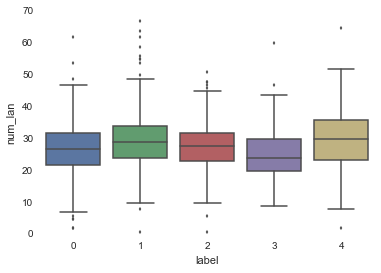

In [67]:
sns.boxplot(talks_small['num_lan'],groupby=talks_small.label)

In [338]:
Xdf1 = talks_small[['id','themes','speaker_gender']]

In [339]:
Xdf1 = Xdf1.sort(columns = 'id')
Xdf1.head()

,id,themes,speaker_gender
0,1,Presentation Innovation A Greener Future? Bold...,1
1,2,A Greener Future? Tales of Invention Rethinkin...,0
758,3,Rethinking Poverty Africa: The Next Chapter Wa...,1
1395,4,What's Next in Tech Tales of Invention To Bold...,1
103,6,Animals That Amaze Evolution's Genius Inspired...,1


In [340]:
caps = pd.read_json('captions_f.json')[['id','length','num_para','word_per_sec','laughter_per_word','laugh_as_para',
                                     'applause_total','div_per_word','ithinks','storywords','noun_token','verb_token']]

In [341]:
caps = caps.sort(columns = 'id')

In [342]:
caps.reset_index(inplace = True, drop = True)

In [343]:
caps.shape

(1535, 12)

In [344]:
caps.head()

,id,length,num_para,word_per_sec,laughter_per_word,laugh_as_para,applause_total,div_per_word,ithinks,storywords,noun_token,verb_token
0,1,944,16,2.265890,0.004675,2,4,0.012155,1,6,summer truck letterman chain show money seques...,help show focus trade bring go find consider b...
1,2,879,27,2.962457,0.002304,5,1,0.005376,9,0,money laptop dollar month front volunteer pape...,move bring go find cut thank promote should ad...
2,3,1099,22,2.261146,0.000402,1,1,0.012877,3,5,sector chain money lack dollar resistance rest...,bomb show mobilize move bring go debate cut de...
3,4,1152,28,2.655382,0.001635,4,2,0.013730,11,0,sector houston atmosphere concept money milest...,help show invent bring kill go find inspire de...
4,6,983,20,2.535097,0.000803,2,0,0.004815,4,0,duty atmosphere code radiation compound millil...,represent help show scratch move vary kill par...


#### read in the processed text (title + keywords + description) 

In [345]:
Xother = pd.read_json('talks_other_text.json')

In [346]:
Xother.sort(columns = 'id',inplace = True)

In [347]:
Xother.reset_index(inplace = True, drop = True)

In [348]:
Xdf1 = pd.merge(Xdf1,caps,on = 'id')

In [349]:
Xdf1 = pd.merge(Xdf1,Xother, on = 'id')

In [350]:
Xdf1.sort(columns = 'id',inplace = True)

In [351]:
labels.sort(columns = 'id',inplace = True)

In [352]:
labels.reset_index(drop = True, inplace = True)

In [353]:
Xdf1.id.head(10)

0     1
1     2
2     3
3     4
4     6
5     7
6     9
7    10
8    12
9    13
Name: id, dtype: int64

In [354]:
labels.head(10)

,id,label
0,1,4
1,2,1
2,3,0
3,4,0
4,6,2
5,7,4
6,9,0
7,10,0
8,12,2
9,13,3


In [355]:
ydf = labels[['label']].values.flatten()

In [356]:
ydf[:5]

array([4, 1, 0, 0, 2])

## 3 Logistic Regression

### 3.1 a single test-train split 

In [357]:
sss = StratifiedShuffleSplit(ydf, n_iter = 1, test_size=0.2, random_state=321)

In [358]:
for train_index,test_index in sss:
    Xtrain,Xtest = Xdf1.ix[train_index,:],Xdf1.ix[test_index,:]
    ytrain,ytest = ydf[train_index],ydf[test_index]
    # trainind = train_index
    # testind = test_index

In [359]:
Xtrain.head()

,id,themes,speaker_gender,length,num_para,word_per_sec,laughter_per_word,laugh_as_para,applause_total,div_per_word,ithinks,storywords,noun_token,verb_token,text
572,924,How the Mind Works Not Business as Usual Uncon...,0,1411.000,30,2.423104,0.003510,11,3,0.002340,0,10,essay duty infant concept poetry show demand s...,represent help show move vary rest bring shape...,Sheena Iyengar studies how we make choices -- ...
1254,1882,Medicine Without Borders,0,780.817,20,2.529402,0.000000,0,1,0.000506,1,4,money move dollar human skin dish biologist di...,represent help show move obtain shake go tend ...,It's relatively easy to imagine a new medicine...
1250,1877,Might You Live a Great Deal Longer?,1,1068.758,18,2.411210,0.000776,0,1,0.000000,1,13,bomb dance move rest course manager planning g...,neglect consider show agonize move vary bring ...,There's an irony behind the latest efforts to ...
26,36,The Power of Cities Tales of Invention Rethink...,1,825.000,26,2.758788,0.000000,0,0,0.009227,3,2,lease salon show money rest month hillside obs...,consider show go find cut violate explain trea...,"Robert Neuwirth, author of ""Shadow Cities,"" fi..."
345,532,"Bold Predictions, Stern Warnings Unconventiona...",1,421.000,9,2.923990,0.000812,1,1,0.002437,2,0,slope insurgency dynamic timing scientist go e...,emerge consume give predict recreate bring see...,By analyzing raw data on violent incidents in ...


In [360]:
pd.Series(ydf).value_counts()

0    474
1    418
2    353
3    179
4    111
dtype: int64

In [361]:
pd.Series(ytest).value_counts()

0    95
1    84
2    71
3    36
4    22
dtype: int64

###3.1.1 the text (kw + title + description) processing 

In [362]:
Xtrain_text = Xtrain['text'].as_matrix()

In [363]:
Xtest_text = Xtest['text'].as_matrix()

####the following list is derived in Ted_5_NLP_other 

In [364]:
final_text_words = ['global issues', 'science', 'culture', 'new','humor','entertainment']

In [365]:
vect_other = CountVectorizer(vocabulary = final_text_words, stop_words = 'english', ngram_range = (1,2))

In [366]:
Xtrain_text_other = vect_other.fit_transform(Xtrain_text)

In [367]:
Xtest_text_other = vect_other.transform(Xtest_text)

###3.1.2 theme processing 

In [368]:
Xtrain_th = Cvtheme.transform(Xtrain.ix[:,'themes'].as_matrix())

In [369]:
Xtest_th = Cvtheme.transform(Xtest.ix[:,'themes'].as_matrix())

###3.1.3 verb and noun tokens in the caption 

#### the vocabulary lists are derived in Ted_2_NLP_caption 

In [370]:
vocab_verb_final = [u'like',u'show',u'feel',u'should',u'leave',u'live',u'understand',u'talk',u'ask',u'become',u'change']

In [371]:
vocab_noun_final = [u'life',u'percent',u'question',u'story',u'idea',u'part',u'place',u'fact',u'example',u'problem',u'bit',u'kind',u'today']

In [372]:
tf_noun = TfidfVectorizer(vocabulary = vocab_noun_final,use_idf = False, sublinear_tf = True)

In [373]:
tf_verb = TfidfVectorizer(vocabulary = vocab_verb_final,use_idf = False, sublinear_tf = True)

In [374]:
Xtrain_noun = tf_noun.fit_transform(Xtrain.ix[:,'noun_token'].as_matrix())

In [375]:
Xtest_noun = tf_noun.transform(Xtest.ix[:,'noun_token'].as_matrix())

In [376]:
Xtrain_verb = tf_verb.fit_transform(Xtrain.ix[:,'verb_token'].as_matrix())

In [377]:
Xtest_verb = tf_verb.transform(Xtest.ix[:,'verb_token'].as_matrix())

### 3.1.4 combine text and non-text features into a data matrix

In [378]:
Xtrainm = np.concatenate([Xtrain_th.toarray(),Xtrain_noun.toarray(),Xtrain_verb.toarray(),
                          Xtrain_text_other.toarray(), scale(Xtrain.ix[:,2:12].as_matrix())],
                         axis = 1)

In [379]:
Xtestm = np.concatenate([Xtest_th.toarray(),Xtest_noun.toarray(),Xtest_verb.toarray(),
                         Xtest_text_other.toarray(), scale(Xtest.ix[:,2:12].as_matrix())],axis = 1)

In [380]:
Xtrainm.shape

(1227, 87)

In [381]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [382]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold

#### To improve the negative class prediction, class_weight can be specified to 'auto'

In [383]:
clf = LogisticRegression(C = 10, penalty = 'l2')

In [384]:
clf.fit(Xtrainm,ytrain)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [385]:
ytest_pred = clf.predict(Xtestm)

In [311]:
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.58      0.66      0.62        95
          1       0.66      0.76      0.71        84
          2       0.57      0.54      0.55        71
          3       0.44      0.22      0.30        36
          4       0.76      0.59      0.67        22

avg / total       0.60      0.60      0.59       308



In [386]:
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.59      0.67      0.63        95
          1       0.66      0.75      0.70        84
          2       0.53      0.54      0.53        71
          3       0.43      0.17      0.24        36
          4       0.72      0.59      0.65        22

avg / total       0.59      0.60      0.58       308



In [108]:
report_precision = [0.52, 0.64, 0.46, 0.47, 0.67]

In [109]:
report_recall = [0.67, 0.62, 0.44, 0.19, 0.64]

In [110]:
report_precision = pd.Series(report_precision, index = fractions.index)

In [111]:
report_recall = pd.Series(report_recall, index = fractions.index)

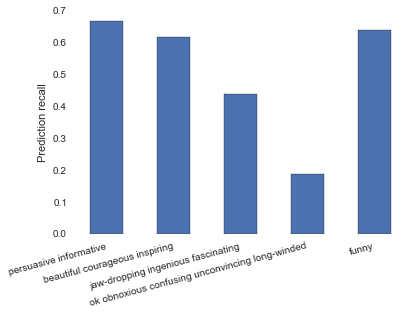

In [112]:
report_recall.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Prediction recall')

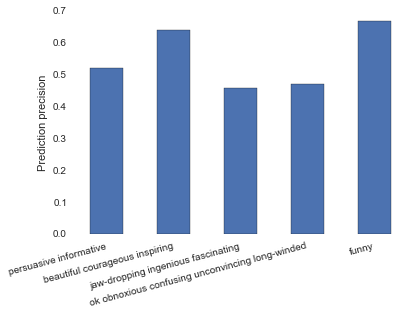

In [188]:
report_precision.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Prediction precision')

###Try SVM 

In [387]:
svm = SVC(random_state = 321,class_weight = 'auto')

In [388]:
svm.fit(Xtrainm, ytrain)

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=321, shrinking=True, tol=0.001, verbose=False)

In [389]:
ytest_pred3 = svm.predict(Xtestm)

In [390]:
print classification_report(ytest, ytest_pred3)

             precision    recall  f1-score   support

          0       0.58      0.60      0.59        95
          1       0.71      0.57      0.63        84
          2       0.48      0.45      0.47        71
          3       0.24      0.28      0.26        36
          4       0.52      0.77      0.62        22

avg / total       0.55      0.53      0.54       308



### The following serves as a benchmark, which includes only themes, length, num_para,  word_per_sec

In [362]:
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.48      0.74      0.58        95
          1       0.55      0.56      0.55        84
          2       0.48      0.44      0.46        71
          3       0.29      0.06      0.09        36
          4       0.75      0.14      0.23        22

avg / total       0.49      0.50      0.46       308



In [124]:
labeldict

{0: ['Informative', 'Persuasive'],
 1: ['Beautiful', 'Courageous', 'Inspiring'],
 2: ['Fascinating', 'Ingenious', 'Jaw-dropping'],
 3: ['Confusing', 'Longwinded', 'OK', 'Obnoxious', 'Unconvincing'],
 4: ['Funny']}

In [422]:
clf.coef_

array([[ -2.35334288e+00,  -1.42258909e+00,  -1.85438523e+00,
         -5.24616524e-01,  -2.37358509e+00,  -3.21799002e-01,
          1.13239663e+00,   2.14013878e-01,   1.14841221e+00,
          4.32212816e-01,   2.32314390e-01,   2.14173869e-01,
         -1.59421044e-01,  -9.25200411e-02,  -5.64633791e-01,
          5.35309043e-01,  -5.51945343e-01,   1.16864308e-01,
          1.29510567e-01,  -5.04819049e-01,  -4.71223057e-01,
         -4.14981345e-01,   4.67345301e-01,  -1.41300753e+00,
         -1.36525691e+00,   8.38499012e-01,  -1.49817587e+00,
         -3.12377758e-01,   5.08687968e-02,  -1.20820666e-02,
         -5.13277816e-03,  -8.03444517e-01,  -5.25906909e-01,
         -2.65959274e-01,   1.88523159e+00,   2.96184010e-01,
         -1.21576491e+00,   6.71768656e-01,   7.90376765e-01,
          4.72099801e-01,  -5.88241330e-01,   5.61112486e-01,
          0.00000000e+00,  -3.45505840e-01,  -1.63452688e+00,
          3.65126316e-01,   5.34011726e-01,   1.20864601e-02,
        

In [391]:
pd.crosstab(ytest_pred,ytest,rownames=['predicted'],colnames = ['true'],margins = True)

true,0,1,2,3,4,All
predicted,,,,,,
0,64,10,22,11,2,109
1,16,63,8,7,1,95
2,10,9,38,9,6,72
3,4,2,2,6,0,14
4,1,0,1,3,13,18
All,95,84,71,36,22,308


### random forest

In [401]:
rf = RandomForestClassifier(n_estimators= 10, criterion='gini')

In [402]:
rf.fit(Xtrainm,ytrain)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [403]:
ytest_pred2 = rf.predict(Xtestm)

In [404]:
print classification_report(ytest, ytest_pred2)

             precision    recall  f1-score   support

          0       0.50      0.66      0.57        95
          1       0.56      0.69      0.62        84
          2       0.51      0.42      0.46        71
          3       0.43      0.08      0.14        36
          4       0.58      0.32      0.41        22

avg / total       0.52      0.52      0.50       308



In [405]:
rf.feature_importances_

array([ 0.00177497,  0.00018772,  0.00094738,  0.00085525,  0.00297597,
        0.00137089,  0.00787931,  0.00265035,  0.00209337,  0.00448874,
        0.00294002,  0.00241886,  0.00335138,  0.        ,  0.0028061 ,
        0.0032138 ,  0.        ,  0.00451268,  0.00414221,  0.01141334,
        0.00113268,  0.00280465,  0.00111575,  0.00672673,  0.00522194,
        0.00773381,  0.00475033,  0.00349333,  0.00290191,  0.00108144,
        0.00515314,  0.00432775,  0.00168917,  0.00663281,  0.00017774,
        0.00311892,  0.00842105,  0.00220843,  0.00128376,  0.00213518,
        0.00808946,  0.00242677,  0.        ,  0.00347339,  0.00055182,
        0.00173532,  0.00036103,  0.03327634,  0.01861102,  0.02244358,
        0.02244699,  0.02011575,  0.01825736,  0.01700055,  0.01673411,
        0.02236872,  0.01780617,  0.01775413,  0.01650163,  0.01812285,
        0.0163902 ,  0.01970447,  0.01978789,  0.01831885,  0.01905738,
        0.01898306,  0.02047835,  0.02121823,  0.01873672,  0.02

### def a function to generate feature importance list based on rf

In [406]:
rf.feature_importances_.shape

(87,)

In [407]:
Xtrain.columns[2:13]

Index([   u'speaker_gender',            u'length',          u'num_para',
            u'word_per_sec', u'laughter_per_word',     u'laugh_as_para',
          u'applause_total',      u'div_per_word',           u'ithinks',
              u'storywords',        u'noun_token'],
      dtype='object')

In [408]:
other_vocab = sorted(vect_other.vocabulary_.items(), key = operator.itemgetter(1))

In [409]:
other_vocab = [x[0] for x in other_vocab]

In [410]:
noun_vocab = sorted(tf_noun.vocabulary_.items(), key = operator.itemgetter(1))

In [411]:
noun_vocab = [x[0] for x in noun_vocab]

In [412]:
verb_vocab = sorted(tf_verb.vocabulary_.items(), key = operator.itemgetter(1))

In [413]:
verb_vocab = [x[0] for x in verb_vocab]

In [417]:
feature_names = list(vocab) + noun_vocab + verb_vocab + other_vocab + list(Xtrain.columns[2:12])

In [418]:
feature_importance = pd.Series(rf.feature_importances_,index = feature_names)

In [419]:
feature_importance.sort(ascending = False)

In [420]:
feature_importance

laughter_per_word                      0.048545
word_per_sec                           0.041195
length                                 0.037920
div_per_word                           0.037348
applause_total                         0.036884
num_para                               0.034394
life                                   0.033276
storywords                             0.025071
story                                  0.022447
question                               0.022444
example                                0.022369
become                                 0.021270
ithinks                                0.021248
talk                                   0.021218
laugh_as_para                          0.021150
understand                             0.020478
idea                                   0.020116
feel                                   0.019788
show                                   0.019704
leave                                  0.019057
live                                   0

### 3.2 With cross_val_score 

transform Xdf1 to matrix, ydf is already an array

In [421]:
y = ydf

In [422]:
Xdf1.shape

(1535, 15)

In [423]:
Xth = Xdf1['themes'].as_matrix()

In [424]:
Xth = Cvtheme.transform(Xth)

In [425]:
Xth.toarray()[0,:]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0])

In [426]:
Xtext_other = vect_other.transform(Xdf1['text'].as_matrix())

In [427]:
X_noun = tf_noun.fit_transform(Xdf1['noun_token'].as_matrix())

In [428]:
X_verb = tf_verb.fit_transform(Xdf1['verb_token'].as_matrix())

In [429]:
X = np.concatenate([Xth.toarray(),X_noun.toarray(), X_verb.toarray(),
                    Xtext_other.toarray(),scale(Xdf1.ix[:,2:12].as_matrix())],axis = 1)

In [430]:
score = cross_val_score(clf,X,y,cv = StratifiedKFold(y,n_folds = 5),scoring = 'f1')

In [431]:
print score.mean(),score

0.544144662709 [ 0.54962259  0.5501008   0.5175636   0.57834961  0.52508672]


In [269]:
# this one has num_lan but does not have the noun and verbs from the captions
print score.mean(),score

0.517080949826 [ 0.51100164  0.53167215  0.51307857  0.51307819  0.51657421]


In [432]:
score3 = cross_val_score(svm,X,y,cv = StratifiedKFold(y,n_folds = 5),scoring = 'f1')

In [433]:
print score3.mean(),score3

0.497097900204 [ 0.43726246  0.53908583  0.49422802  0.50864857  0.50626462]


In [271]:
# this one has num_lan but does not have the noun and verbs from the captions
print score3.mean(),score3

0.488740670094 [ 0.43706197  0.54650451  0.52757732  0.4924674   0.44009215]
